In [7]:
from pathlib import Path
import torch
import pandas as pd
import stat
import numbers
import pydicom
import numpy as np
from tqdm import tqdm
from collections import Counter
import re
import os
from PIL import Image
from matplotlib import pyplot as plt
import cv2
import json
import seaborn as sns

In [11]:
sns.set(style="whitegrid", font_scale=1.2)

In [2]:
Path().resolve()

PosixPath('/home/buehlern/Documents/Masterarbeit/notebooks')

In [3]:
df_loc = Path('../data/df_min.pkl')
df = pd.read_pickle(df_loc)

In [4]:
df

,patientid,path,pixelarr_shape,inverted,bodypart,fracture,foreignmaterial
0,-0XIAZI2mBM,/home/buehlern/neocortex-nas/shared/Skelett/BW...,"(2947, 1140)",False,tspine,NaN,NaN
1,-0XIAZI2mBM,/home/buehlern/neocortex-nas/shared/Skelett/BW...,"(3001, 2220)",False,tspine,NaN,NaN
2,-1qIJOjCmUA,/home/buehlern/neocortex-nas/shared/Skelett/BW...,"(2903, 1267)",False,tspine,NaN,NaN
3,-1qIJOjCmUA,/home/buehlern/neocortex-nas/shared/Skelett/BW...,"(2622, 1132)",False,tspine,NaN,NaN
4,-1qIJOjCmUA,/home/buehlern/neocortex-nas/shared/Skelett/BW...,"(2834, 1261)",False,tspine,NaN,NaN
...,...,...,...,...,...,...,...
639872,zzYDEupARTA,/home/buehlern/neocortex-nas/shared/Skelett/SG...,"(3056, 1250)",True,ankle,NaN,NaN
639873,zztrIVB0lEM,/home/buehlern/neocortex-nas/shared/Skelett/SG...,"(1654, 960)",False,ankle,NaN,NaN
639874,zztrIVB0lEM,/home/buehlern/neocortex-nas/shared/Skelett/SG...,"(1485, 831)",False,ankle,NaN,NaN
639875,zzuYHa4Yo7I,/home/buehlern/neocortex-nas/shared/Skelett/SG...,"(1791, 880)",False,ankle,NaN,NaN


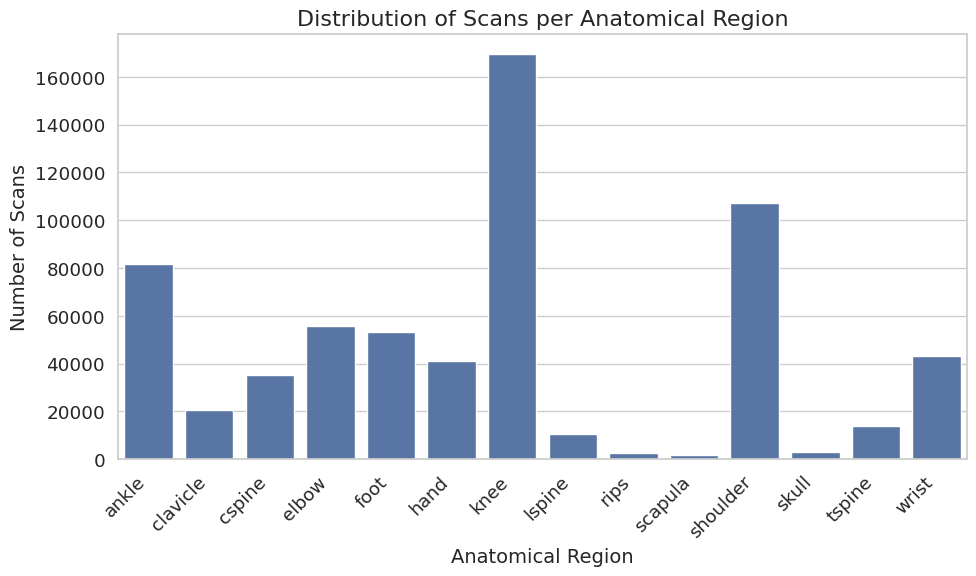

In [13]:
bodypart_counts = df['bodypart'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
sns.barplot(x=bodypart_counts.index, y=bodypart_counts.values)
plt.xlabel("Anatomical Region", fontsize=14)
plt.ylabel("Number of Scans", fontsize=14)
plt.title("Distribution of Scans per Anatomical Region", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("export/bodypart_histogram.png", dpi=300)
plt.show()

x cutoff points: [ 246. 1543. 2002. 2438. 3072.]
y cutoff points: [ 219. 1117. 1417. 1852. 3071.]


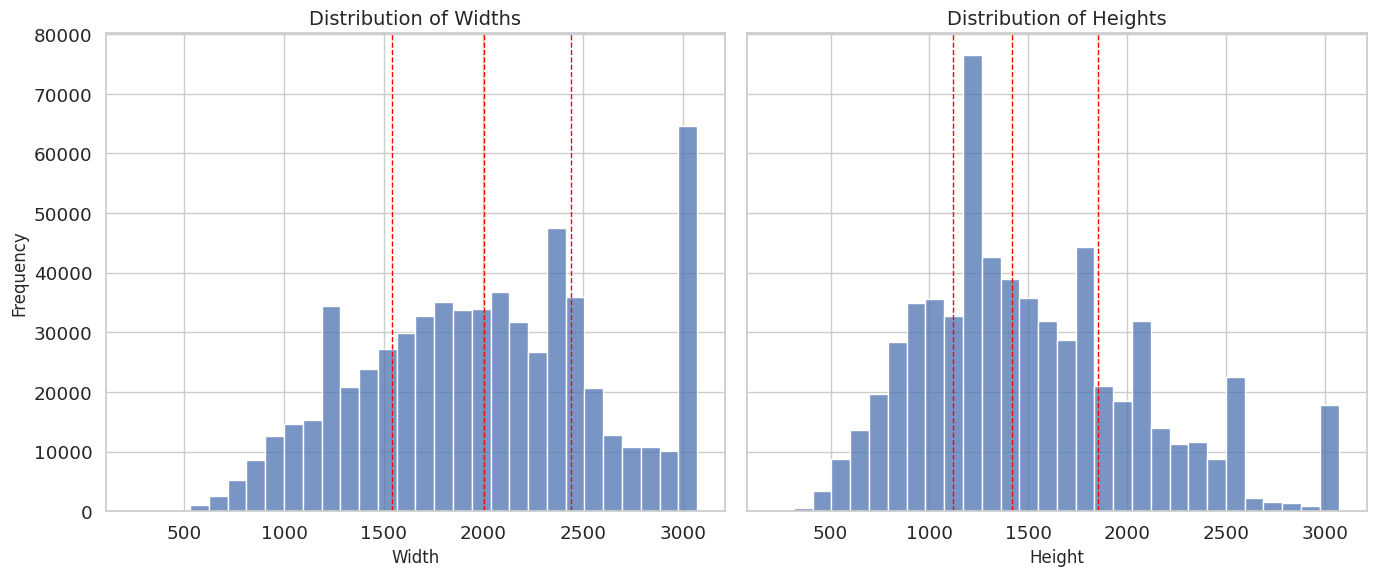

In [30]:
df[['x', 'y']] = df['pixelarr_shape'].tolist()

x_bins = np.percentile(df['x'], [0, 25, 50, 75, 100])
y_bins = np.percentile(df['y'], [0, 25, 50, 75, 100])

print("x cutoff points:", x_bins)
print("y cutoff points:", y_bins)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Width histogram
sns.histplot(df['x'], bins=30, kde=False, ax=axes[0])
axes[0].set_title("Distribution of Widths", fontsize=14)
axes[0].set_xlabel("Width", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)

for q in x_bins[1:-1]:
    axes[0].axvline(q, linestyle='--', color='red', linewidth=1)

# Height histogram
sns.histplot(df['y'], bins=30, kde=False, ax=axes[1])
axes[1].set_title("Distribution of Heights", fontsize=14)
axes[1].set_xlabel("Height", fontsize=12)
axes[1].set_ylabel("Frequency", fontsize=12)

for q in y_bins[1:-1]:
    axes[1].axvline(q, linestyle='--', color='red', linewidth=1)

plt.tight_layout()
plt.savefig("export/resolution_histogram.png", dpi=300)
plt.show()

In [39]:
def pad_to_bin(size, bins=[1152, 1536, 1920, 2304, 2688, 3072]):
    # expects bins to be sorted
    for bin_size in bins:
        if size <= bin_size:
            return bin_size
    assert(False)

def pad_to(size, patch_size=48):
    return int(np.ceil(size / patch_size) * patch_size)

df['bin_x'] = df['x'].apply(lambda x: pad_to_bin(x))
df['bin_y'] = df['y'].apply(lambda y: pad_to_bin(y))

df['pad_x'] = df['x'].apply(lambda x: pad_to(x))
df['pad_y'] = df['y'].apply(lambda y: pad_to(y))

raw_pixels = (df['x'] * df['y']).sum()
pad_pixels = (df['pad_x'] * df['pad_y']).sum()
pad_tokens = pad_pixels / 48**2
bin_pixels = (df['bin_x'] * df['bin_y']).sum()
bin_tokens = bin_pixels / 48**2
fix_pixels = 3072 * 3072 * len(df)
fix_tokens = fix_pixels / 48**2

print("Raw pixels", raw_pixels)
print("Padded pixels", pad_pixels, "Padded tokens", pad_tokens)
print("Binned pixels", bin_pixels, "Binned tokens", bin_tokens)
print("Fixed size pixels", fix_pixels, "Fixed size tokens", fix_tokens)

print("Padded/Raw Ratio", pad_pixels / raw_pixels)
print("Binned/Pad Ratio", bin_pixels / pad_pixels)
print("Fixed/Pad Ratio", fix_pixels / pad_pixels)
print("Binned/Fixed Ratio", bin_pixels / fix_pixels)
print("Binned/Fixed Compute Ratio", (bin_pixels / fix_pixels)**2)

Raw pixels 2071693646109
Padded pixels 2123526451968 Padded tokens 921669467.0
Binned pixels 2536770650112 Binned tokens 1101028928.0
Fixed size pixels 6038636986368 Fixed size tokens 2620936192.0
Padded/Raw Ratio 1.025019532186311
Binned/Pad Ratio 1.194602802221287
Fixed/Pad Ratio 2.843683430819348
Binned/Fixed Ratio 0.42008994013693257
Binned/Fixed Compute Ratio 0.1764755578042516


In [41]:
df['bodypart'].unique()

array(['tspine', 'clavicle', 'rips', 'skull', 'elbow', 'foot', 'hand',
       'wrist', 'cspine', 'knee', 'lspine', 'scapula', 'shoulder',
       'ankle'], dtype=object)

/tmp/ipykernel_2538732/1756991681.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  images = df.groupby('bodypart').apply(lambda x: x.sample(1)).reset_index(drop=True)


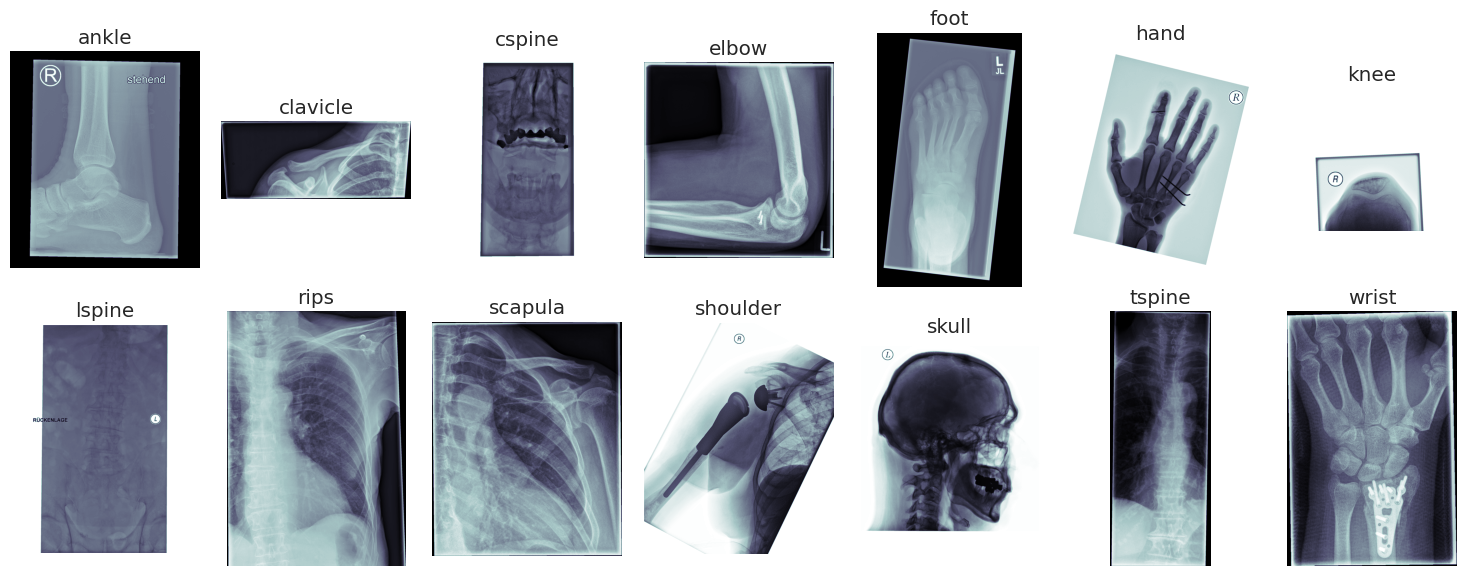

In [51]:
bps = df['bodypart'].unique()
images = df.groupby('bodypart').apply(lambda x: x.sample(1)).reset_index(drop=True)

n = len(bps)
cols = 7
rows = 2

fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))

for i, (index, row) in enumerate(images.iterrows()):
    ax = axes[i // cols, i % cols]
    img = pydicom.dcmread(row['path']).pixel_array
    ax.imshow(img, cmap=plt.cm.bone)
    ax.set_title(row['bodypart'])
    ax.axis('off')

plt.tight_layout()
plt.savefig("export/bodyparts.png", dpi=300)
plt.show()